In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten)
from tensorflow.keras.layers import (Dense, Lambda, Dropout, Activation)

from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
STYLES_CSV_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
IMAGES_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

In [3]:
df = pd.read_csv(STYLES_CSV_PATH, error_bad_lines = False, warn_bad_lines=False)
print(f"Total Rows: {df.shape[0]}\nTotal Columns: {df.shape[1]}")
df.head()

Total Rows: 44424
Total Columns: 10


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
print('NaN Count:')
df.isna().sum()

NaN Count:


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [5]:
df = df.dropna()
df = df.drop(['year', 'productDisplayName', 'masterCategory', 'subCategory'], axis=1)
df = df.sample(30000)
df = df[df['id'].isin([int(i.split('.')[0]) for i in os.listdir(IMAGES_PATH)])]

# Pre-processing

Adding `.jpg` to id column

In [6]:
df['id'] = df['id'].apply(lambda x: IMAGES_PATH+str(x) +'.jpg')
image_ids = df.pop('id')

In [7]:
df

,gender,articleType,baseColour,season,usage
14507,Unisex,Footballs,White,Fall,Sports
31511,Men,Watches,Copper,Winter,Casual
43142,Women,Kurta Sets,Grey,Fall,Ethnic
36545,Men,Shirts,Navy Blue,Summer,Casual
17496,Men,Watches,Black,Winter,Casual
...,...,...,...,...,...
1423,Women,Handbags,Purple,Summer,Casual
30145,Men,Socks,Black,Summer,Casual
17726,Men,Trousers,Navy Blue,Summer,Casual
20442,Women,Tops,Teal,Summer,Casual


Binning values with < 50 samples

In [8]:
def bin_values(x):
    x_vc = df[x].value_counts()
    x_other = x_vc[x_vc<50].index
    df.loc[df[x].isin(x_other),x] = 'Other'
    
for col in df.columns:
    bin_values(col)

In [9]:
df

,gender,articleType,baseColour,season,usage
14507,Unisex,Other,White,Fall,Sports
31511,Men,Watches,Copper,Winter,Casual
43142,Women,Kurta Sets,Grey,Fall,Ethnic
36545,Men,Shirts,Navy Blue,Summer,Casual
17496,Men,Watches,Black,Winter,Casual
...,...,...,...,...,...
1423,Women,Handbags,Purple,Summer,Casual
30145,Men,Socks,Black,Summer,Casual
17726,Men,Trousers,Navy Blue,Summer,Casual
20442,Women,Tops,Teal,Summer,Casual


Load Images

In [10]:
from keras.applications.resnet import preprocess_input

IMAGE_DIMS = (60, 60, 3)

def load_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

image_data = []
for img_path in tqdm(image_ids):
    image_data.append(load_image(img_path))
    
image_data = np.array(image_data, dtype="float")

Using TensorFlow backend.
100%|██████████| 29997/29997 [20:09<00:00, 24.81it/s] 


Load other features

In [11]:
articleTypeLB = LabelBinarizer()
genderLB = LabelBinarizer()
baseColourLB = LabelBinarizer()
seasonLB = LabelBinarizer()
usageLB = LabelBinarizer()

articleTypeLabels = articleTypeLB.fit_transform(np.array(df['articleType'].values))
genderLabels = genderLB.fit_transform(np.array(df['gender'].values))
baseColourLabels = baseColourLB.fit_transform(np.array(df['baseColour'].values))
seasonLabels = seasonLB.fit_transform(np.array(df['season'].values))

split = train_test_split(image_data,
                         articleTypeLabels, 
                         genderLabels, 
                         baseColourLabels, 
                         seasonLabels, 
                         test_size=0.2, random_state=42)

(trainX, testX,
 trainArticleTypeY, testArticleTypeY,
 trainGenderY, testGenderY,
 trainBaseColourY, testBaseColourY,
 trainSeasonY, testSeasonY
)  = split

In [12]:
from tensorflow.keras.applications import ResNet50

In [13]:
def make_branch(res_input, n_out, act_type, name):
    z = Dense(512, activation="relu")(res_input)
    z = Dense(256, activation='relu')(z)
    z = Dense(128, activation='relu')(z)
    z = BatchNormalization()(z)
    z = Dropout(0.5)(z)

    if name == 'article':
        z = Dense(256, activation='relu')(z)
        z = Dense(128, activation='relu')(z)
        z = Dense(64, activation='relu')(z)
        z = Dense(n_out, activation='softmax', name='article_output_new')(z)
        z = Activation(act_type, name=name+'_output')(z)
    elif name == 'gender':
        z = Dense(64, activation='relu')(z)
        z = Dense(n_out, activation='softmax', name='gender_output_new')(z)
        z = Activation(act_type, name=name+'_output')(z)
    elif name == 'color':
        z = Dense(64, activation='relu')(z)
        z = BatchNormalization()(z)
        z = Dropout(0.5)(z)
        z = Dense(32, activation='relu')(z)
        z = Dense(n_out, activation='sigmoid', name='color_output_new')(z)
        z = Lambda(lambda x: tf.clip_by_value(x, 1e-7, 1 - 1e-7))(z)
        z = Activation(act_type, name=name+'_output')(z)
    elif name == 'season':
#         z = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(res_input)
#         z = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(z)
#         z = MaxPooling2D(pool_size=2)(z)
#         z = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(z)
#         z = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(z)
#         z = MaxPooling2D(pool_size=2)(z)
#         z = Flatten()(z)
#         z = Dense(128, activation='relu')(z)
#         z = Dense(64, activation='relu')(z)
#         z = Dense(n_out, activation='softmax', name=name+'_output')(z)
#         z = Activation(act_type, name=name+'_output')(z)
#         z = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(z)
#         z = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(z)
#         z = MaxPooling2D(pool_size=2)(z)
#         z = Flatten()(z)
        z = Dense(64, activation='relu')(z)
        z = Dense(n_out, activation='softmax', name='season_output_new')(z)
        z = Activation(act_type, name=name+'_output')(z)

    return z


In [14]:
def build_model(width, height):

    # -------------------------
    res50 = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_DIMS)
    res50.trainable=False
    inputs = Input(shape=IMAGE_DIMS)
    x = res50(inputs, training=False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    # -------------------------

    article_branch = make_branch(x, len(articleTypeLB.classes_), 'softmax', 'article')
    gender_branch = make_branch(x, len(genderLB.classes_), 'softmax', 'gender')
    color_branch = make_branch(x, len(baseColourLB.classes_), 'softmax', 'color')
    season_branch = make_branch(x, len(seasonLB.classes_), 'softmax', 'season')

    model = Model(inputs=inputs,
                outputs=[article_branch, gender_branch, color_branch, 
                            season_branch])
    return model

In [15]:
import os
import pickle
from keras.callbacks import ModelCheckpoint

# define the path to save the best model
output_dir = '/kaggle/working/'

# define the checkpoint file name
checkpoint_file = os.path.join(output_dir, 'best_model.pkl')



In [16]:
model = build_model(60, 60)

losses = {
    "article_output": "categorical_crossentropy",
    "gender_output": "categorical_crossentropy",
    "color_output": "categorical_crossentropy",
    "season_output": "categorical_crossentropy",
}

EPOCHS = 20
INIT_LR = 1e-5
BS = 16

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, metrics=["accuracy"])

94773248/94765736 [==============================] - 1s 0us/step


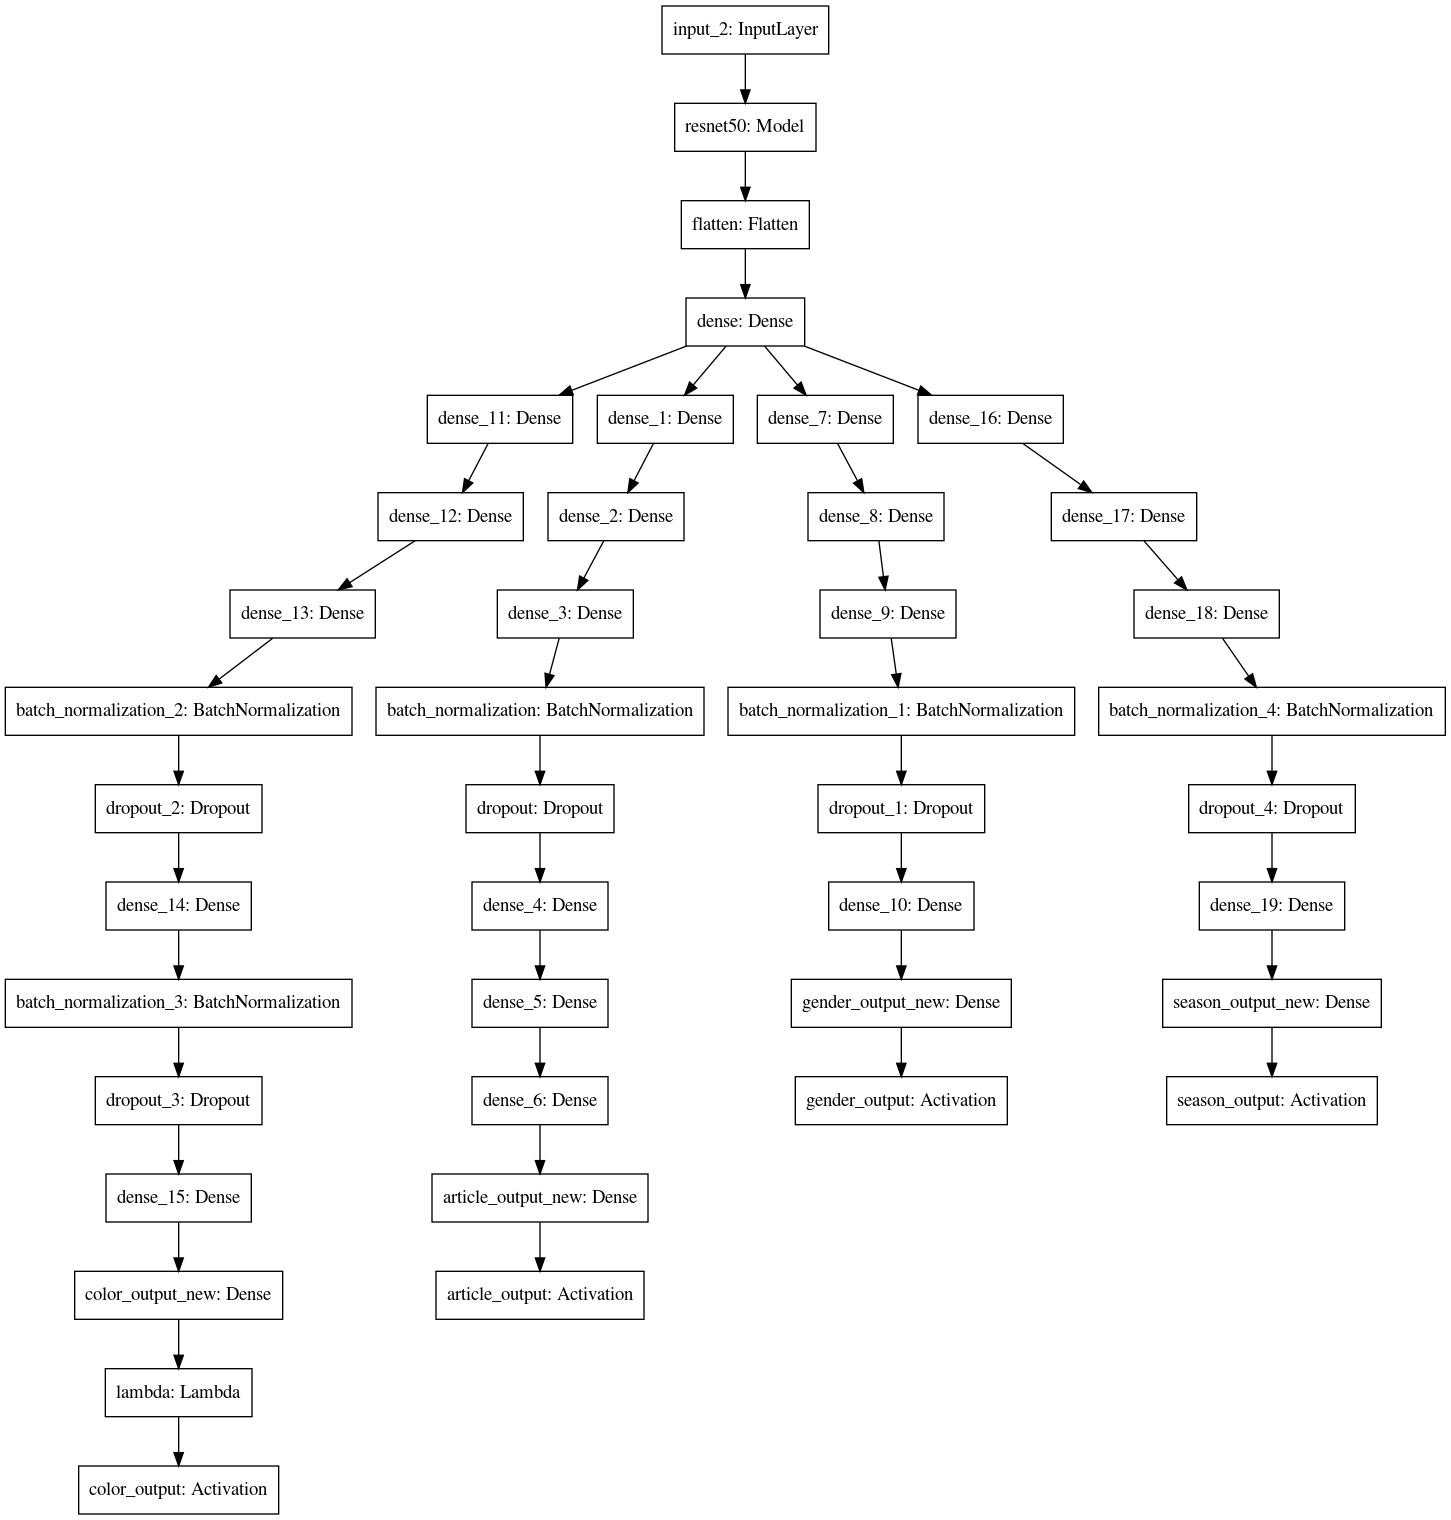

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [18]:
# set up the checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
H = model.fit(trainX,
    {"article_output": trainArticleTypeY,
    "gender_output": trainGenderY,
    "color_output": trainBaseColourY,
    "season_output": trainSeasonY,
    },
    validation_data=(testX, 
    {"article_output": testArticleTypeY,
    "gender_output": testGenderY,
    "color_output": testBaseColourY,
    "season_output": testSeasonY,
    }),
    epochs= EPOCHS,
    batch_size=BS,
    verbose = 1, callbacks = [checkpoint])
              
#     verbose=1 , callbacks = [checkpoint])

In [22]:
import os

if os.path.isfile(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        best_model = pickle.load(f)
else:
    print(f"{checkpoint_file} is not a valid file path.")

    
# /kaggle/working/best_model.pkl/saved_model.pb


    
model.save(os.path.join(output_dir, 'final_model.h5'))

# # Define the path to the saved weights
# saved_weights_path = '/kaggle/working/best_weights.h5'

# # Create the model
# model = build_model(60, 60)

# # Load the saved weights into the model
# model.load_weights(saved_weights_path)


# # Save the model parameters
# model.save("best_model.h5")

/kaggle/working/best_model.pkl is not a valid file path.


In [23]:
# %matplotlib inline
h_df = pd.DataFrame(H.history)
h_df.loc[:,[col for col in h_df.columns if 'accuracy' in col and 'val' not in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'accuracy' in col and 'val' in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'loss' in col and 'val' not in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'loss' in col and 'val' in col]].plot()

In [24]:
res = model.evaluate(testX, 
    {"article_output": testArticleTypeY,
    "gender_output": testGenderY,
    "color_output": testBaseColourY,
    "season_output": testSeasonY }, batch_size=32, verbose=0)

#     "usage_output": testUsageY 

print('loss', res[:5])
print('acc', list(map(lambda x: round(x*100,2), res[5:])))

loss [8.688660769144693, 3.6304574, 1.0383614, 2.968775, 1.0519983]
acc [52.6, 86.55, 46.45, 68.7]


In [26]:
idx=20

# (categoryProba, genderProba, ageProba, colorProba, styleProba) = model.predict(np.expand_dims(testX[idx], axis=0))

(categoryProba, genderProba, ageProba, colorProba) = model.predict(np.expand_dims(testX[idx], axis=0))

categoryIdx = categoryProba[0].argmax()
genderIdx = genderProba[0].argmax()
ageIdx = ageProba[0].argmax()
colorIdx = colorProba[0].argmax()
# styleIdx = styleProba[0].argmax()
categoryLabel = articleTypeLB.classes_[categoryIdx]
genderLabel = genderLB.classes_[genderIdx]
ageLabel = baseColourLB.classes_[ageIdx]
colorLabel = seasonLB.classes_[colorIdx]
# styleLabel = usageLB.classes_[styleIdx]

categoryText = "Category: {} ({:.2f}%)".format(categoryLabel, categoryProba[0][categoryIdx] * 100)
genderText = "Gender: {} ({:.2f}%)".format(genderLabel, genderProba[0][genderIdx] * 100)
ageText = "Age: {} ({:.2f}%)".format(ageLabel, ageProba[0][ageIdx] * 100)
colorText = "Color: {} ({:.2f}%)".format(colorLabel, colorProba[0][colorIdx] * 100)
# styleText = "Style: {} ({:.2f}%)".format(styleLabel, styleProba[0][styleIdx] * 100)

print(categoryText, '-----', articleTypeLB.classes_[testArticleTypeY[idx].argmax()])
print(genderText, '-----',genderLB.classes_[testGenderY[idx].argmax()])
print(ageText, '-----',baseColourLB.classes_[testBaseColourY[idx].argmax()])
print(colorText, '-----',seasonLB.classes_[testSeasonY[idx].argmax()])
# print(styleText, '-----',usageLB.classes_[testUsageY[idx].argmax()])

Category: Handbags (4.27%) ----- Handbags
Gender: Women (40.46%) ----- Women
Age: White (5.82%) ----- Blue
Color: Summer (47.53%) ----- Summer
